In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
device = torch.device("cuda")

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.tensor([[1, 2, 3], [1, 2, 3]]).to(device)

tensor([[1, 2, 3],
        [1, 2, 3]], device='cuda:0')

In [12]:
batch_size = 100
train_datasets = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=False)
test_datasets = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=False)
train_data = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_datasets, batch_size=batch_size, shuffle=True)

In [13]:
description = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

deer


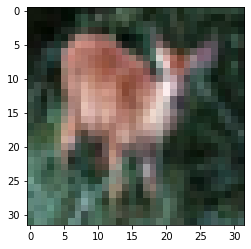

In [14]:
images, labels = next(iter(test_data))
plt.imshow(images[0].permute(1, 2, 0))
print(description[labels[0].item()])

In [15]:
def caculate_infos(size,parameters):
    return (parameters[1],((size-parameters[2]+2*parameters[4])/parameters[3])+1)
caculate_infos(16,(256,512,3,1,1))


(512, 16.0)

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 64,16*16
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 128,8*8
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 256,4*4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 512,2*2
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Flatten()
        ) # 1024,2*2
        self.fc1 = nn.Sequential(
            nn.Linear(1024*2*2, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.out = nn.Linear(256,10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

net = CNN()
net = net.to(device)

In [17]:
loss_function = nn.CrossEntropyLoss()

In [18]:
def train(epochs=1, learning_rate=0.001):
    max_record = 0.42085 # 手动修改
    net.load_state_dict(torch.load('CNN-CIFAR10.pkl'))
    for epoch in range(epochs):
        net.train()
        # net.load_state_dict(torch.load('CNN-CIFAR10.pkl'))
        for i, (images, labels) in enumerate(train_data):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            optimizer = optim.Adam(net.parameters(), lr=learning_rate)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total = 10000
        correct = 0
        net.eval()
        for i, (images, labels) in enumerate(test_data):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.tolist()
            outputs = net(images)
            predict = torch.max(outputs,1).indices.tolist()
            total += len(predict)
            for i in range(len(predict)):
                if predict[i] == labels[i]:
                    correct += 1
        print(f"epoch {epoch}: {correct/total*100}%")
        if correct/total>max_record:
            max_record = correct/total
            torch.save(net.state_dict(),'CNN-CIFAR10.pkl')
            print(f"发现新的最高精度，保存模型,精度为{max_record}")
            
train(50, learning_rate=0.01)

epoch 0: 38.23%
发现新的最高精度，保存模型,精度为0.3823
epoch 1: 35.66%
epoch 2: 38.05%
epoch 3: 38.665%
发现新的最高精度，保存模型,精度为0.38665
epoch 4: 37.580000000000005%
epoch 5: 37.915%
epoch 6: 39.57%
发现新的最高精度，保存模型,精度为0.3957
epoch 7: 34.9%
epoch 8: 40.129999999999995%
发现新的最高精度，保存模型,精度为0.4013
epoch 9: 39.129999999999995%
epoch 10: 39.635%
epoch 11: 38.105%
epoch 12: 38.845%
epoch 13: 39.900000000000006%
epoch 14: 40.635%
发现新的最高精度，保存模型,精度为0.40635
epoch 15: 38.685%
epoch 16: 37.585%
epoch 17: 38.945%
epoch 18: 39.68%
epoch 19: 39.645%
epoch 20: 39.89%
epoch 21: 40.585%
epoch 22: 41.545%
发现新的最高精度，保存模型,精度为0.41545
epoch 23: 40.550000000000004%
epoch 24: 40.96%
epoch 25: 40.805%
epoch 26: 40.665%
epoch 27: 40.53%
epoch 28: 39.96%
epoch 29: 41.675000000000004%
发现新的最高精度，保存模型,精度为0.41675
epoch 30: 41.585%
epoch 31: 41.175%
epoch 32: 41.14%
epoch 33: 40.56%
epoch 34: 40.89%
epoch 35: 39.09%
epoch 36: 41.6%
epoch 37: 39.715%
epoch 38: 41.730000000000004%
发现新的最高精度，保存模型,精度为0.4173
epoch 39: 42.085%
发现新的最高精度，保存模型,精度为0.42085
ep

KeyboardInterrupt: 

In [27]:
total = 10000
correct = 0
for i, (images, labels) in enumerate(test_data):
    images = images.to(device)
    labels = labels.tolist()
    outputs = net(images)
    predict = torch.max(outputs,1).indices.tolist()
    total += len(predict)
    for i in range(len(predict)):
        if predict[i] == labels[i]:
            correct += 1
print(f" {correct/total*100}%")

 5.04%


In [152]:
len(test_datasets)

10000